In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
# Define constants
image_size = (128, 128)  # Adjust the size based on your dataset
batch_size = 32

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/bone-fracture-dataset/BoneFractureDataset/training',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/bone-fracture-dataset/BoneFractureDataset/testing',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [11]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Nadam, Adamax


# Build the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
# Train the model
history = model.fit(
    train_generator, 
    epochs=15,
    validation_data=test_generator
   )

Epoch 1/15
277/277 [==============================] - 44s 154ms/step - loss: 0.6697 - accuracy: 0.5926 - val_loss: 3.9253 - val_accuracy: 0.6183
Epoch 2/15
277/277 [==============================] - 43s 155ms/step - loss: 0.8970 - accuracy: 0.6370 - val_loss: 11.6097 - val_accuracy: 0.6067
Epoch 3/15
277/277 [==============================] - 42s 152ms/step - loss: 1.4124 - accuracy: 0.6937 - val_loss: 9.6033 - val_accuracy: 0.6250
Epoch 4/15
277/277 [==============================] - 43s 154ms/step - loss: 0.8008 - accuracy: 0.7395 - val_loss: 3.8144 - val_accuracy: 0.6533
Epoch 5/15
277/277 [==============================] - 42s 152ms/step - loss: 0.7015 - accuracy: 0.7731 - val_loss: 15.4036 - val_accuracy: 0.7633
Epoch 6/15
277/277 [==============================] - 43s 154ms/step - loss: 1.0348 - accuracy: 0.7915 - val_loss: 2.1148 - val_accuracy: 0.6733
Epoch 7/15
277/277 [==============================] - 42s 151ms/step - loss: 0.5072 - accuracy: 0.8211 - val_loss: 3.8521 - val_

In [21]:
# Evaluate the model
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

19/19 [==============================] - 1s 55ms/step - loss: 4.7769 - accuracy: 0.8067
Test Accuracy: 80.67%


In [22]:
# Make predictions on new data
predictions = model.predict(test_generator)

19/19 [==============================] - 1s 51ms/step


In [23]:
# Convert predictions to binary labels
predicted_labels = (predictions > 0.5).astype(int)

In [24]:
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels
true_labels = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[195 165]
 [141  99]]


In [25]:
# Generate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=['not_fractured', 'fractured'])
print("Classification Report:")
print(class_report)

Classification Report:
               precision    recall  f1-score   support

not_fractured       0.58      0.54      0.56       360
    fractured       0.38      0.41      0.39       240

     accuracy                           0.49       600
    macro avg       0.48      0.48      0.48       600
 weighted avg       0.50      0.49      0.49       600



1/1 [==============================] - 0s 82ms/step


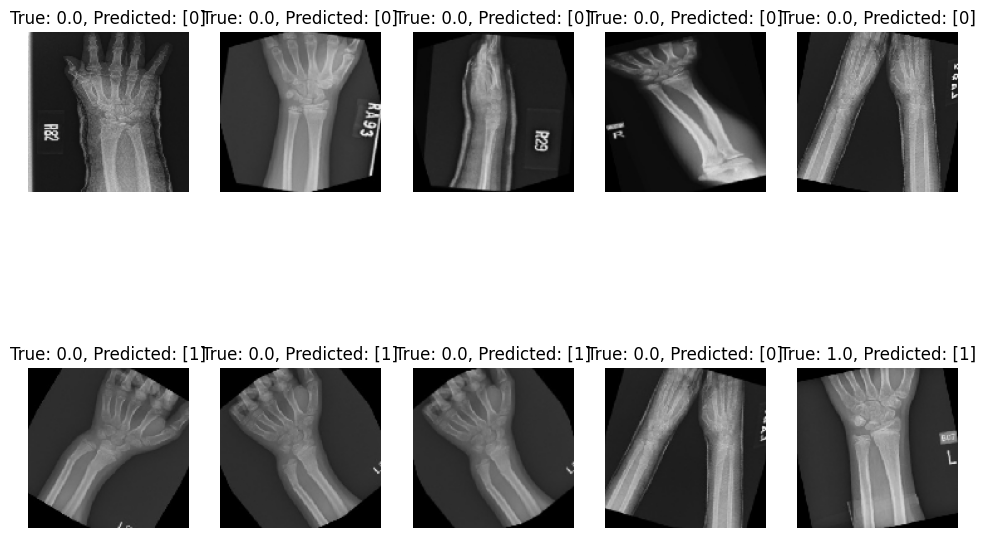

In [26]:
import matplotlib.pyplot as plt
import random

# Visualize random predictions
test_images, true_labels = next(test_generator)
predicted_labels = (model.predict(test_images) > 0.5).astype(int)

# Plot some sample images with true and predicted labels
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[i])
    plt.title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
    plt.axis('off')
plt.show()

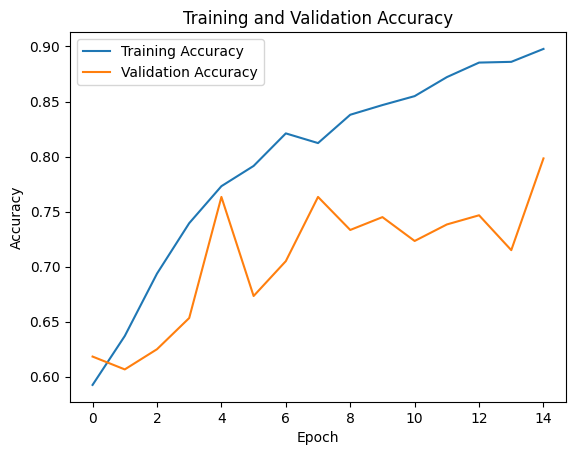

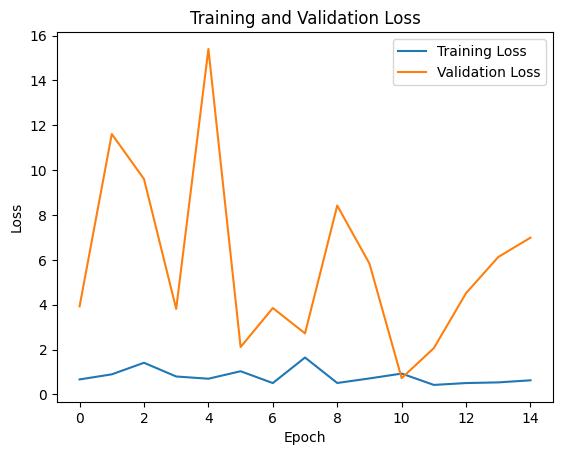

In [27]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Shallow Neural Network Baseline

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Get the image dimensions
image_shape = (128, 128, 3)

# Build a shallow neural network model
shallow_model = Sequential([
    Flatten(input_shape=image_shape),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile and train the shallow model
shallow_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# Create a data generator for the training data
train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/bone-fracture-dataset/BoneFractureDataset/training',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

# Train the shallow model
shallow_model.fit(train_generator, epochs=5, validation_data=test_generator)

# Evaluate the shallow model
shallow_accuracy = shallow_model.evaluate(test_generator)[1]

# Get the predictions
y_pred = (shallow_model.predict(test_generator) > 0.5).astype(int)

# Get the true labels
y_test = test_generator.classes

# Calculate the classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
shallow_report = classification_report(y_test, y_pred, target_names=['not_fractured', 'fractured'])
shallow_conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Shallow Neural Network Accuracy: {shallow_accuracy * 100:.2f}%")
print("Shallow Neural Network Classification Report:\n", shallow_report)
print("Shallow Neural Network Confusion Matrix:\n", shallow_conf_matrix)

Found 8863 images belonging to 2 classes.
Epoch 1/5
277/277 [==============================] - 43s 153ms/step - loss: 0.6593 - accuracy: 0.5856 - val_loss: 0.6618 - val_accuracy: 0.4567
Epoch 2/5
277/277 [==============================] - 42s 153ms/step - loss: 0.6214 - accuracy: 0.6386 - val_loss: 0.6936 - val_accuracy: 0.5367
Epoch 3/5
277/277 [==============================] - 43s 156ms/step - loss: 0.6035 - accuracy: 0.6599 - val_loss: 0.6137 - val_accuracy: 0.5167
Epoch 4/5
277/277 [==============================] - 42s 153ms/step - loss: 0.5763 - accuracy: 0.6881 - val_loss: 0.6725 - val_accuracy: 0.5033
Epoch 5/5
19/19 [==============================] - 1s 55ms/step
Shallow Neural Network Accuracy: 57.50%
Shallow Neural Network Classification Report:
                precision    recall  f1-score   support

not_fractured       0.62      0.40      0.49       360
    fractured       0.41      0.62      0.50       240

     accuracy                           0.49       600
    macro

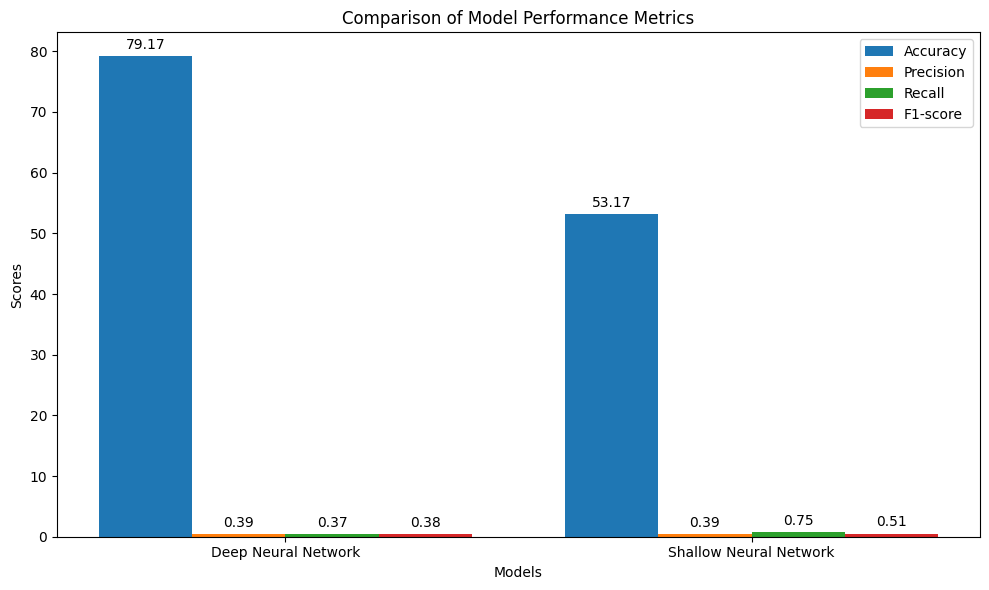

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Define metrics for comparison
models = ['Deep Neural Network', 'Shallow Neural Network']
#accuracies = [80.67, 57.50]
#precisions = [0.39, 0.39]  # Update with your precision values
#recalls = [0.37, 0.75]  # Update with your recall values
#f1_scores = [0.38, 0.51]  # Update with your F1-score values

# Plotting the comparison
x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
accuracy_bars = ax.bar(x, accuracies, width, label='Accuracy')
#precision_bars = ax.bar(x + width, precisions, width, label='Precision')
#recall_bars = ax.bar(x + 2 * width, recalls, width, label='Recall')
#f1_score_bars = ax.bar(x + 3 * width, f1_scores, width, label='F1-score')

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance Metrics')
ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels(models)
ax.legend()

# Function to add labels on top of the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels for each metric
add_labels(accuracy_bars)
#add_labels(precision_bars)
#add_labels(recall_bars)
#add_labels(f1_score_bars)

plt.tight_layout()
plt.show()


In [34]:
import pandas as pd

# Define the models
models = ['Deep Neural Network', 'Shallow Neural Network']

# Define the performance metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

# Define the values for each metric (replace with your actual values)
deep_neural_network_values = [79.17, 0.39, 0.37, 0.38]
shallow_neural_network_values = [53.17, 0.39, 0.75, 0.51]

# Create a DataFrame
data = {
    'Metric': metrics,
    'Deep Neural Network': deep_neural_network_values,
    'Shallow Neural Network': shallow_neural_network_values
}

df = pd.DataFrame(data)

# Set the 'Metric' column as the index
df.set_index('Metric', inplace=True)

# Print the DataFrame
print(df)


           Deep Neural Network  Shallow Neural Network
Metric                                                
Accuracy                 79.17                   53.17
Precision                 0.39                    0.39
Recall                    0.37                    0.75
F1-score                  0.38                    0.51


# Trying transfer learning

# 1 -> VGG16

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report

# Define constants
image_size = (128, 128)
batch_size = 32

# Load pre-trained VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Freeze the convolutional base
for layer in vgg_model.layers:
    layer.trainable = False

# Add custom classifier on top
custom_model = Sequential([
    vgg_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the custom model
custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the custom model
history = custom_model.fit(train_generator, epochs=10, validation_data=test_generator)

# Evaluate the custom model
evaluation = custom_model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])

# Make predictions on test data
predictions = custom_model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int)

# Get true labels
true_labels = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=['not_fractured', 'fractured'])
print("Classification Report:")
print(class_report)


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
277/277 [==============================] - 48s 164ms/step - loss: 0.5895 - accuracy: 0.6836 - val_loss: 0.5698 - val_accuracy: 0.6367
Epoch 2/10
277/277 [==============================] - 43s 155ms/step - loss: 0.4309 - accuracy: 0.7968 - val_loss: 0.6305 - val_accuracy: 0.7217
Epoch 3/10
277/277 [==============================] - 43s 155ms/step - loss: 0.3484 - accuracy: 0.8477 - val_loss: 0.6920 - val_accuracy: 0.6917
Epoch 4/10
277/277 [==============================] - 44s 159ms/step - loss: 0.3132 - accuracy: 0.8623 - val_loss: 0.9148 - val_accuracy: 0.6583
Epoch 5/10
 45/277 [===>..........................] - ETA: 35s - loss: 0.3013 - accuracy: 0.8687

# 2 -> DenseNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report

# Define constants
image_size = (128, 128)
batch_size = 32

# Load pre-trained DenseNet121 model
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Freeze the convolutional base
for layer in densenet_model.layers:
    layer.trainable = False

# Add custom classifier on top
custom_model_densenet = Sequential([
    densenet_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the custom model
custom_model_densenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the custom model
history_densenet = custom_model_densenet.fit(train_generator, epochs=10, validation_data=test_generator)

# Evaluate the custom model
evaluation_densenet = custom_model_densenet.evaluate(test_generator)
print("Test Accuracy (DenseNet):", evaluation_densenet[1])

# Make predictions on test data
predictions_densenet = custom_model_densenet.predict(test_generator)
predicted_labels_densenet = (predictions_densenet > 0.5).astype(int)

# Get true labels
true_labels_densenet = test_generator.classes

# Generate confusion matrix
conf_matrix_densenet = confusion_matrix(true_labels_densenet, predicted_labels_densenet)
print("Confusion Matrix (DenseNet):")
print(conf_matrix_densenet)

# Generate classification report
class_report_densenet = classification_report(true_labels_densenet, predicted_labels_densenet, target_names=['not_fractured', 'fractured'])
print("Classification Report (DenseNet):")
print(class_report_densenet)
